<!-- !conda install -c conda-forge numpy-financial -y -->

In [221]:
import datetime
import yfinance as yf

# Lista para armazenar os trades
trades = []

# Função para registrar um trade
def registrar_trade(data, tipo, quantidade, preco):
    trade = {
        'data': data,
        'tipo': tipo,
        'quantidade': quantidade,
        'preco': preco
    }
    trades.append(trade)

# Função para obter o preço atual da ação
def obter_preco_atual(ticker):
    acao = yf.Ticker(ticker)
    preco_atual = acao.history(period="1d")['Close'][0]
    return preco_atual

# Função para calcular a rentabilidade
def calcular_rentabilidade(ticker):
#     Esta função calcula a rentabilidade em termos percentuais.
    investido = 0
    quantidade_acoes = 0

    for trade in trades:
        if trade['tipo'] == 'compra':
            investido += trade['quantidade'] * trade['preco']
            quantidade_acoes += trade['quantidade']
        else:
            investido -= trade['quantidade'] * trade['preco']
            quantidade_acoes -= trade['quantidade']

    preco_atual = obter_preco_atual(ticker)
    valor_atual = quantidade_acoes * preco_atual

    rentabilidade = ((valor_atual - investido) / investido) * 100
    return rentabilidade

# Adicionando trades de exemplo
registrar_trade(datetime.date(2020, 8, 25), 'compra', 10, 122.6)
registrar_trade(datetime.date(2021, 8, 4), 'venda', 5, 145.05)
registrar_trade(datetime.date(2021, 8, 25), 'compra', 15, 146.66)
registrar_trade(datetime.date(2022, 11, 21), 'venda', 5, 147.38)

# Calculando a rentabilidade acumulada para a APPLE
rentabilidade = calcular_rentabilidade("AAPL")
print(f"Rentabilidade acumulada: {rentabilidade:.2f}%")


Rentabilidade acumulada: 36.47%


In [222]:
obter_preco_atual("AAPL")

178.6699981689453

https://numpy.org/numpy-financial/

In [223]:
import yfinance as yf
import numpy_financial as npf
import datetime

# Lista para armazenar os trades e fluxos de caixa
ticker = 'AAPL'
trades = []
fluxo_caixa = []

# Função para obter o preço na data
def obter_preco_na_data(ticker, data):
    acao = yf.Ticker(ticker)
    # Busca dados para um intervalo de 7 dias em torno da data desejada
    inicio = (datetime.datetime.strptime(data, '%Y-%m-%d') - datetime.timedelta(days=3)).strftime('%Y-%m-%d')
    fim = (datetime.datetime.strptime(data, '%Y-%m-%d') + datetime.timedelta(days=3)).strftime('%Y-%m-%d')
    historico = acao.history(start=inicio, end=fim)
    
    # Verifica se a data desejada está nos dados retornados
    if data in historico.index:
        return historico.loc[data]['Close']
    else:
        return None

# Função para registrar um trade
def registrar_trade(ticker, data, tipo, quantidade, preco=None):
    if preco is None:
        preco = obter_preco_na_data(ticker, data)
        if preco is None:
            print(f"Não foi possível obter o preço para {ticker} na data {data}.")
            return
    
    if tipo == 'compra':
        fluxo = -quantidade * preco
    else:
        fluxo = quantidade * preco
    fluxo_caixa.append(fluxo)
    
    trade = {
        'ticker': ticker,
        'data': data,
        'tipo': tipo,
        'quantidade': quantidade,
        'preco': preco
    }
    trades.append(trade)

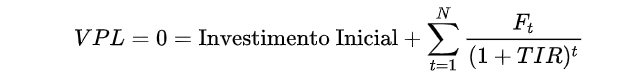

In [224]:
# Função para calcular a TIR
def calcular_TIR():
    return npf.irr(fluxo_caixa) * 100

from scipy.optimize import fsolve
import warnings

def calcular_TIR_alternativo():
    # Função para calcular o VPL para uma taxa dada
    def vpl(taxa):
        return sum([fc / (1 + taxa)**i for i, fc in enumerate(fluxo_caixa)])
    valores_iniciais = [i/100 for i in range(-100, 101)]
    # Usa fsolve para encontrar a taxa que faz o VPL ser zero
    # Suprimir avisos durante o cálculo
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        for valor_inicial in valores_iniciais:
            tir = fsolve(vpl, valor_inicial)[0]
            # Verifica se a solução encontrada é válida
            if abs(vpl(tir)) < 1e-5:
                return tir * 100


# Função para calcular rentabilidade ITD(Inception to Date)
def calcular_rentabilidade_ITD(ticker):
    preco_inicial = trades[0]['preco']
    preco_atual = obter_preco_na_data(ticker, datetime.date.today().strftime('%Y-%m-%d'))
    return ((preco_atual - preco_inicial) / preco_inicial) * 100


def calcular_rendimento(ticker): 
    #Esta função calcula o rendimento em termos absolutos (em reais ou na moeda que você estiver usando).
    # Valor Inicial
    valor_inicial = trades[0]['quantidade'] * trades[0]['preco']
    
    # Número total de ações após todos os trades
    total_acoes = sum([trade['quantidade'] if trade['tipo'] == 'compra' else -trade['quantidade'] for trade in trades])    
    #list comprehention
    
    # Valor Atual
    preco_atual = obter_preco_na_data(ticker, datetime.date.today().strftime('%Y-%m-%d'))
    valor_atual = total_acoes * preco_atual
    
    # Rendimento
    rendimento = valor_atual - valor_inicial
    
    return rendimento

# Registra trades fictícios ao longo dos últimos 2 anos
# data_inicial = (datetime.date.today() - datetime.timedelta(days=2*365)).strftime('%Y-%m-%d')

registrar_trade("AAPL", '2021-08-25', 'compra', 15)
registrar_trade("AAPL", "2021-08-04", 'venda', 5)
registrar_trade("AAPL", "2020-08-25", 'compra', 10)
registrar_trade("AAPL", "2022-11-21", 'venda', 20)

trades = sorted(trades, key=lambda x: x['data'])
fluxo_caixa = [-trade['preco'] * trade['quantidade'] if trade['tipo'] == 'compra' else trade['preco'] * trade['quantidade'] for trade in trades]

# Calcula a TIR e rentabilidade ITD
tir = calcular_TIR()
print(f"TIR: {tir:.2f}%")
tir = calcular_TIR_alternativo()
print(f"TIR alternativo: {tir:.2f}%")
rentabilidade_itd = calcular_rentabilidade_ITD("AAPL")
print(f"Rentabilidade ITD(Inception to Date): {rentabilidade_itd:.2f}%")
rendimento = calcular_rendimento(ticker)
print(f"Rendimento : {rendimento:.2f}")

TIR: 5.38%
TIR alternativo: 5.38%
Rentabilidade ITD(Inception to Date): 45.72%
Rendimento : -1226.09


##### Fluxo de Caixa:

- Compra de 15 ações em 2020-08-20 por -1742.63.
- Venda de 5 ações em 2021-08-04 por 725.26.
- Compra de 10 ações em 2021-08-25 por -1466.63.
- Venda de 5 ações em 2022-11-21 por 736.91.

outra maneira de ver:
- 2020-08-20: Você comprou 15 ações da AAPL a um preço de 116.17 por ação. Portanto, você gastou 15 * 116.17 = 1742.62. Isso é um fluxo de caixa negativo, pois é uma saída de dinheiro.
- 2021-08-04: Você vendeu 5 ações da AAPL a um preço de 145.05 por ação. Portanto, você recebeu 5 * 145.05 = 725.26. Isso é um fluxo de caixa positivo, pois é uma entrada de dinheiro.
- 2021-08-25: Você comprou 10 ações da AAPL a um preço de 146.66 por ação. Portanto, você gastou 10 * 146.66 = 1466.63. Isso é um fluxo de caixa negativo.
- 2022-11-21: Você vendeu 5 ações da AAPL a um preço de 147.38 por ação. Portanto, você recebeu 5 * 147.38 = 736.90. Isso é um fluxo de caixa positivo.

##### Resultados:

TIR: -64.85%

Rentabilidade ITD (Inception to Date): 44.55%

Interpretação:

Rentabilidade ITD (Inception to Date):

A rentabilidade ITD de 44.55% indica que, desde a primeira transação até a data atual, o valor das ações da Apple aumentou 44.55%. Isso é uma medida absoluta de quanto o valor das ações aumentou desde a primeira compra.

##### Taxa Interna de Retorno (TIR):
A TIR é uma métrica que representa a taxa de retorno anual composta que torna o Valor Presente Líquido (VPL) de um fluxo de caixa igual a zero.Ou seja a TIR é uma métrica financeira que indica a rentabilidade anual de um investimento. Ela mostra qual seria a taxa de juros que faria com que o valor total investido e o valor total recebido ao longo do tempo se equilibrassem, ou seja, que o lucro ou prejuízo fosse zero. Se você tivesse outros lugares para investir seu dinheiro, a TIR seria a taxa que você usaria para comparar a atratividade desses investimentos.

**Quando a TIR é negativa**, como -64.85%, significa que, se você olhar ano a ano, em média, **o valor do seu investimento caiu 64.85%** em relação ao que você inicialmente colocou. Isso **não significa que você perdeu mais da metade do seu dinheiro**, mas que, em média anualmente, **o retorno foi negativo nessa taxa.**

##### Como isso é possível?
A TIR é altamente sensível ao momento e à magnitude dos fluxos de caixa. Se você tiver grandes saídas de caixa (compras) seguidas por pequenas entradas de caixa (vendas) e depois grandes entradas de caixa (vendas) no final, a TIR pode ser negativa mesmo que a rentabilidade geral seja positiva.

No nosso caso, tivemos duas grandes compras seguidas por vendas menores. Mesmo que o valor das ações tenha aumentado ao longo do tempo (como indicado pela rentabilidade ITD positiva), o fato de termos comprado mais ações (grandes saídas de caixa) antes de vender (entradas de caixa) afetou negativamente a TIR.

Em resumo, enquanto a rentabilidade ITD fornece uma visão geral de quanto o valor das ações aumentou desde a primeira compra, a TIR fornece uma visão mais detalhada de como o investimento se saiu ao longo do tempo, levando em consideração o momento e a magnitude dos fluxos de caixa.


A avaliação de um investimento com base na TIR e na rentabilidade ITD pode ser um pouco complexa, especialmente quando os dois indicadores parecem contar histórias diferentes. Vamos analisar:

Rentabilidade ITD Positiva: Se a rentabilidade desde o início (ITD) é positiva, isso indica que, no geral, você ganhou dinheiro com o investimento. O valor total do seu investimento cresceu desde que você começou a investir.

TIR Negativa: Uma TIR negativa sugere que, em média anualmente, o retorno foi negativo na taxa indicada. Isso pode ser devido a várias razões, como grandes saídas de dinheiro (compras de ações) em momentos inoportunos ou vendas em momentos de baixa. A TIR leva em consideração o momento e a magnitude dos fluxos de caixa, o que significa que o timing das suas transações teve um impacto significativo no retorno anualizado.

##### Avaliação:

Se você ganhou dinheiro no final (como indicado pela rentabilidade ITD positiva), isso é, obviamente, um resultado favorável. No entanto, a TIR negativa sugere que o caminho para esse ganho pode ter sido volátil ou mal cronometrado.

A TIR negativa indica que, se você tivesse outras opções de investimento que oferecessem uma TIR positiva, teria sido mais vantajoso investir nelas, pois teriam proporcionado um melhor retorno anualizado pelo dinheiro.

A atratividade do investimento depende não apenas dos retornos, mas também de outros fatores como risco, liquidez, horizonte de investimento e objetivos pessoais. Se o investimento em questão era de alto risco, uma TIR negativa pode ser uma consequência aceitável desse risco.

##### Conclusão:
Embora você tenha ganhado dinheiro, o investimento pode não ter sido o mais eficiente em termos de retorno anualizado. Vale a pena refletir sobre o timing das suas transações e considerar se houve oportunidades alternativas que poderiam ter oferecido melhores retornos ao longo do tempo. No entanto, o mais importante é que você teve um ganho líquido, e aprender com as experiências passadas pode ajudar a tomar decisões de investimento mais informadas no futuro.

In [225]:
fluxo_caixa

[-1226.0877990722656,
 725.2603149414062,
 -2199.9483489990234,
 2947.6239013671875]

In [226]:
trades

[{'ticker': 'AAPL',
  'data': '2020-08-25',
  'tipo': 'compra',
  'quantidade': 10,
  'preco': 122.60877990722656},
 {'ticker': 'AAPL',
  'data': '2021-08-04',
  'tipo': 'venda',
  'quantidade': 5,
  'preco': 145.05206298828125},
 {'ticker': 'AAPL',
  'data': '2021-08-25',
  'tipo': 'compra',
  'quantidade': 15,
  'preco': 146.66322326660156},
 {'ticker': 'AAPL',
  'data': '2022-11-21',
  'tipo': 'venda',
  'quantidade': 20,
  'preco': 147.38119506835938}]

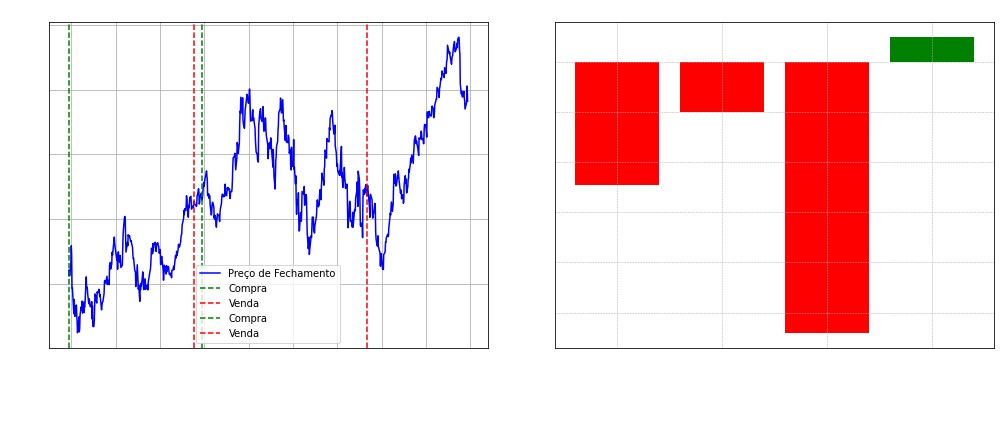

In [227]:
import matplotlib.pyplot as plt
import yfinance as yf
import datetime

def visualizar_dados(ticker):
    # Obter dados históricos do ticker
    acao = yf.Ticker(ticker)
    historico = acao.history(start=trades[0]['data'], end=datetime.date.today().strftime('%Y-%m-%d'))
    
    # Listas para armazenar dados para o gráfico
    datas = []
    montantes = []
    montante_atual = 0
    
    # Calcular montante para cada trade
    for trade in trades:
        if trade['tipo'] == 'compra':
            montante_atual -= trade['quantidade'] * trade['preco']
        else:
            montante_atual += trade['quantidade'] * trade['preco']
        datas.append(trade['data'])
        montantes.append(montante_atual)
    
    # Configurações de cor
    cor_texto = 'white'
    
    # Gráfico de linha para preços
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(historico.index, historico['Close'], label='Preço de Fechamento', color='blue')
    
    # Adicionar linhas pontilhadas para trades
    for trade in trades:
        data_trade = datetime.datetime.strptime(trade['data'], '%Y-%m-%d')  # Convertendo para datetime
        if trade['tipo'] == 'compra':
            plt.axvline(x=data_trade, color='green', linestyle='--', label='Compra')
        else:
            plt.axvline(x=data_trade, color='red', linestyle='--', label='Venda')
    
    plt.title('Evolução dos Preços de ' + ticker, color=cor_texto)
    plt.xlabel('Data', color=cor_texto)
    plt.ylabel('Preço', color=cor_texto)
    plt.grid(True)
    plt.legend()
    plt.tick_params(colors=cor_texto, rotation = 45)
    
    # Gráfico de barra para montantes
    plt.subplot(1, 2, 2)
    plt.bar(datas, montantes, color=['green' if m > 0 else 'red' for m in montantes])
    plt.title('Montante em Reais ao Longo do Tempo', color=cor_texto)
    plt.xlabel('Data', color=cor_texto)
    plt.ylabel('Montante (R$)', color=cor_texto)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tick_params(colors=cor_texto, rotation = 45)
    
    # Mostrar gráficos
    plt.tight_layout()
    plt.show()

# Chamar a função de visualização
visualizar_dados("AAPL")


In [228]:
def calcular_rendimento_total(ticker):
    # Valor total gasto na compra
    total_compra = sum([trade['quantidade'] * trade['preco'] for trade in trades if trade['tipo'] == 'compra'])
    
    # Valor total recebido nas vendas
    total_venda = sum([trade['quantidade'] * trade['preco'] for trade in trades if trade['tipo'] == 'venda'])
    
    # Número total de ações após todos os trades
    total_acoes = sum([trade['quantidade'] if trade['tipo'] == 'compra' else -trade['quantidade'] for trade in trades])
    
    # Valor atual das ações que você ainda possui
    preco_atual = obter_preco_na_data(ticker, datetime.date.today().strftime('%Y-%m-%d'))
    valor_atual = total_acoes * preco_atual
    
    # Rendimento total
    rendimento_total = (total_venda + valor_atual) - total_compra
    
    return rendimento_total

# Chamar a função e imprimir o rendimento total
rendimento_total = calcular_rendimento_total("AAPL")
print(f"Rendimento total: R$ {rendimento_total:.2f}")


Rendimento total: R$ 246.85


###### Trades:

- Compra de 10 ações por 122.61 cada = -1226.09
- Venda de 5 ações por 145.05 cada = +725.26
- Compra de 15 ações por 146.66 cada = -2199.95
- Venda de 5 ações por 147.38 cada = +736.90

### Cálculos:

###### Rendimento (calcular_rentabilidade):

Cálculos usando a função calcular_rentabilidade:

Investido após cada trade:

- Compra: 1226.10
- Venda: 1226.10 - 725.26 = 500.84
- Compra: 500.84 + 2199.95 = 2700.79
- Venda: 2700.79 - 736.91 = 1963.88

Valor atual das ações que você ainda possui:

Quantidade de ações após todos os trades: 10 - 5 + 15 - 5 = 15
Valor atual: 15 * 177.23 = 2658.45
Rentabilidade acumulada:
**Rentabilidade = ((2658.45 - 1963.88) / 1963.88) * 100 = 35.35%**

######  Rendimento (calcular_rendimento):
- Valor inicial: 10 * 122.61 = -1226.10
- Valor atual: (10 - 5 + 15 - 5) * 177.59 = 15 * 177.59 = 2663.85

**Rendimento = 2663.85 - 1226.10 = 1437.75**

######  Rendimento total (calcular_rendimento_total):
- Total gasto na compra: 1226.10 + 2199.95 = 3426.05
- Total recebido nas vendas: 725.26 + 736.91 = 1462.17

Valor atual das ações que você ainda possui: 15 * 177.59 = 2663.85

**Rendimento total = (1462.17 + 2663.85) - 3426.05 = 699.97**


